In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### Create SnakesAndLadders & Agent Classes

In [2]:
#create the environment for the snakes and ladders
class SnakesAndLadders:
    def __init__(self):
        """Create the Snakes & Ladders Board"""
        self.board = np.zeros(101)
        self.ladders = {3:51, 6:27, 36:55, 20:60, 63:95, 68:98}
        self.snakes = {34:1, 25:5, 47:19, 65:52, 87:57, 91:61, 99:69}
        self.curr = 1
    
    def reset(self):
        """Reset the board when done"""
        self.board = np.zeros(101)
        self.curr = 1
        
    def step(self, action):
        """Take a step within the environment"""
        reward = -1 #for all transitions except 
                    #squares with snakes and ladders
        terminal = False #player has not won
        self.curr += action #take the number of steps player chose
        
        #if current state more than 100, we have to 
        #move backwards instead.
        if self.curr > 100:
            back = self.curr - 100
            self.curr -= 2*back
        
        #check if we landed on a snake or ladder
        #if snake, descend. if ladder, ascend.
        if self.curr in self.ladders.keys():
            self.curr = self.ladders[self.curr]
        if self.curr in self.snakes.keys():
            self.curr = self.snakes[self.curr]
        
        #check if current is terminal
        #NOTE: only terminal when exactly at 100
        if self.curr == 100:
            terminal = True
            reward = 1
        
        self.board[self.curr] += 1
        
        return self.curr, reward, terminal
            
    def showBoard(self):
        """Shows board and how many times agent has landed in the state"""
        print("Snakes and Ladders game board:")
        
        print(np.round(self.board[:100], 1).reshape(10,10))
        
    def getCurrent(self):
        """returns current state"""
        return self.curr
    
    def setCurrent(self, curr):
        self.curr = curr


In [3]:
#we create our agent that is going to play the 
#Snakes & Ladders game
class Agent:
    def __init__(self, alpha, gamma, epsilon):
        """Declare agent variables"""
        self.Q = np.zeros((101, 6)) #100 states X 6 actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = []
        
    def reset(self):
        self.actions = []
        
    def roll_dice(self):
        """Generate a roll of the dice"""
        #NOTE: the dice will be an unfair die
        diceRoll = np.random.choice(range(1,7), p = (0.25,0.15,0.2,0.15,0.15,0.1))
        return diceRoll
        
    def ep_greedy(self, state):
        """follow epsilon greedy policy to choose action"""
        diceRoll = self.roll_dice() #we roll the dice
        if np.random.random() < self.epsilon:
            #we choose the number of steps limited from the diceRoll
            action = np.random.randint(1,diceRoll+1)
        else:
            action = np.argmax(self.Q[state])+1 #we do this, otherwise
                                                #the action returned is
                                                #one less than what we roll.
        
        self.actions.append(action)
        return action 
    
    def updateQ(self, s, a, s_prime, r):
        self.Q[s,a] += self.alpha * (r + self.gamma*max(self.Q[s_prime]) - self.Q[s,a])
        
    def getQValues(self):
        return self.Q
    
    def getActions(self):
        return self.actions
    
    def resetQ(self):
        self.Q = np.zeros((101, 6))
    

### Create QLearning and dynaQ functions

In [4]:
def QLearning(num_episodes, env, agent):
    actionList = []
    for ep in tqdm(range(num_episodes)):
        pass
        #get current state from environment
        state = env.getCurrent()
        while True:
            #using epsilon-greedy policy, get action
            #from Agent object
            action = agent.ep_greedy(state)
            #take a step in the environment to get 
            #subsequent state and reward
            state_prime, reward, terminal = env.step(action)
            if terminal:
                break
            #using Agent object, update its Q values
            agent.updateQ(state,action-1,state_prime,reward)
            state = state_prime
        actionList.append(agent.getActions())
        agent.reset()
        env.reset()
    return actionList

In [5]:
def DynaQ(env, agent, model, max_steps, n_planning_steps):
    
    state = env.getCurrent()
    steps = max_steps
    
    for t in range(max_steps):
        action = agent.ep_greedy(state)
        state_prime, reward, terminal = env.step(action)
        
        if terminal:
            steps = t
            break
            
        model[state, action-1] = [state_prime, reward]
        
        agent.updateQ(state, action-1, state_prime, reward)
        
        for k in range(n_planning_steps):
            candidates = np.array(np.where(~np.isnan(model[:,:,0]))).T
            
            #get random index of candidate 
            #AKA random previously observed state
            idx = np.random.choice(len(candidates))
            
            state_, action_ = candidates[idx]
            
            #use model to find the next state and reward
            #NOTE: we don't have to deduct the action by 1 here
            #because the model already has the right indexing.
            state_next, reward_ = model[state_,action_]
            
            #update q values
            agent.updateQ(state_,action_,int(state_next),reward_)
            
        state = state_prime
        
    return model, steps
    

### Test Agent and SnakeAndLadders Class Functions

In [6]:
def testSAndL():
    SAndL = SnakesAndLadders()
    while True:
        action = np.random.randint(1,7)
        state_prime, reward, terminal = SAndL.step(action)
        if terminal:
            break
    SAndL.showBoard()

In [7]:
def testStep(s):
    SAndL = SnakesAndLadders()
    print('{:^15}{:^15}{:^15}{:^15}'.format('Input State', 'Dice Roll', 'Next State', 'Reward'))
    for i in range(1,7):
        SAndL.setCurrent(s)
        state_prime, reward, terminal = SAndL.step(i)
        print('{:^15}{:^15}{:^15}{:^15}'.format(s, i, state_prime, reward))
    
        

In [8]:
def testRollDice():
    test_agent = Agent(0.5,0.8,0.05)
    freq = dict()
    for i in range(1000):
        roll = test_agent.roll_dice()
        if roll not in freq.keys():
            freq[roll] = 1
        else:
            freq[roll] += 1
    print('{:^15}{:^15}'.format("Dice Roll", "Frequency"))
    for roll, f in sorted(freq.items()):
        print('{:^15}{:^15}'.format(roll, f/1000))
        

In [9]:
testSAndL()

Snakes and Ladders game board:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [10]:
testStep(0)
testStep(20)
testStep(41)
testStep(60)
testStep(95)
testStep(98)

  Input State     Dice Roll     Next State       Reward     
       0              1              1             -1       
       0              2              2             -1       
       0              3             51             -1       
       0              4              4             -1       
       0              5              5             -1       
       0              6             27             -1       
  Input State     Dice Roll     Next State       Reward     
      20              1             21             -1       
      20              2             22             -1       
      20              3             23             -1       
      20              4             24             -1       
      20              5              5             -1       
      20              6             26             -1       
  Input State     Dice Roll     Next State       Reward     
      41              1             42             -1       
      41              2 

In [11]:
testRollDice()

   Dice Roll      Frequency   
       1            0.259     
       2            0.172     
       3            0.186     
       4            0.131     
       5            0.141     
       6            0.111     


### Run Algorithms

In [12]:
alpha = 0.5
gamma = 1
epsilon = 0.05
num_episodes = 5000
max_steps = 1000
n_planning_steps = [1,10,100]
n_experiments = 5

#### Q-Learning

In [13]:
QLearningAgent = Agent(alpha, gamma, epsilon)
snakesAndLadders = SnakesAndLadders()
actionList = QLearning(num_episodes, snakesAndLadders, QLearningAgent)

100%|██████████| 5000/5000 [00:01<00:00, 3441.90it/s]


#### Dyna-Q

In [14]:
DynaQAgent = Agent(alpha, gamma, epsilon)
snakesAndLadders_ = SnakesAndLadders()
steps_per_episode = np.zeros((len(n_planning_steps), n_experiments, num_episodes))

for i, k_steps in enumerate(n_planning_steps):
    
    for j in tqdm(range(n_experiments)):
        model = np.nan*np.zeros((100, 6, 2))
        DynaQAgent.resetQ()
        
        for l in range(num_episodes):
            model, steps = DynaQ(snakesAndLadders_, DynaQAgent, model, max_steps, k_steps)
            steps_per_episode[i,j,l] = steps
            snakesAndLadders_.reset()
        

100%|██████████| 5/5 [04:11<00:00, 50.24s/it]


### Visualizations

In [15]:
def plot_heatmap_max_val(env, value, algoTitle, ax=None):
    """Generate heatmap showing maximum value at each state"""
    if ax is None:
        fig, ax = plt.subplots()
    
    if value.ndim == 1:
        value_max = np.reshape(value[:100], (10,10))
    else:
        value_max = np.reshape(value[:100].max(axis=1), (10,10))
    value_max = value_max[::-1,:]
    
    im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
    ax.set(title='Maximum value per state for ' + algoTitle)
    ax.set_xticks(np.linspace(0, 10-1, num=10))
    ax.set_xticklabels(["%d" % x for x in np.arange(10)])
    ax.set_yticks(np.linspace(0, 10-1, num=10))
    
    ax.set_yticklabels(["%d" % y for y in np.arange(
              0, 100, 10)][::-1])
    
    return im

In [16]:
def plot_actionNum_vs_episodes(num_episodes, actionList, algoTitle, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set(title='actionNum vs Episodes for ' + algoTitle)
    ax.set_xlabel('Num of Episodes')
    ax.set_ylabel('Number of Actions taken')
    #xticks = np.linspace(0, 1000-1, num=100)
    #xticklabels = ["%d" % x for x in np.arange(1000)]
    #ax.set_xticks(xticks, xticklabels)
    
    actionLen = []
    for i in actionList:
        actionLen.append(len(i))
    
    ax.plot(np.arange(num_episodes), actionLen)
    

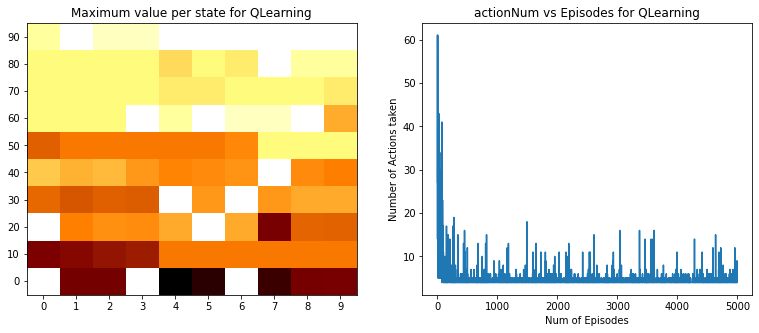

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
plot_heatmap_max_val(snakesAndLadders, QLearningAgent.getQValues(), 'QLearning', ax[0])
plot_actionNum_vs_episodes(num_episodes, actionList, "QLearning", ax[1])

Text(0.5, 0, 'Episodes')

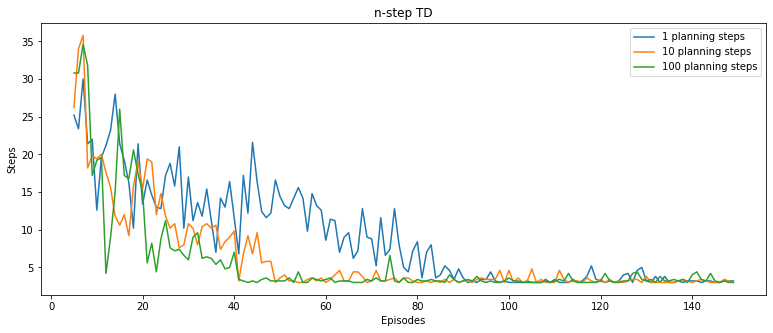

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5))
n_planning_steps = [1,10,100]

for i , k_steps in enumerate(n_planning_steps):
    
    ax.plot(range(5,150), np.mean(steps_per_episode[i,:,5:150], axis=(0)).T, label = str(n_planning_steps[i]) + " planning steps" )
    
ax.legend()
ax.title.set_text("n-step TD")
ax.set_ylabel("Steps")
ax.set_xlabel("Episodes")